In [33]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors

class GridWorld:
    def __init__(self, grid_size, start_state, goal_states, obstacles, traps, action_penalty=-0.1):
        # state space
        self.grid_size = grid_size
        self.start_state = np.array(start_state) # give as tuple
        self.goal_states = [np.array(state) for state in goal_states] # give as list of tuples
        self.obstacles = [np.array(obstacle) for obstacle in obstacles] # give as list of tuples
        self.traps = [np.array(trap) for trap in traps] # give as list of tuples
        self.current_state = np.array(start_state) # give as tuple
        self.action_penalty = action_penalty

        # action space
        self.actions = {
            0: np.array([-1, 0]),  # up
            1: np.array([1, 0]),   # down
            2: np.array([0, -1]),  # left
            3: np.array([0, 1]),   # right
        }

        # initialize rewards
        self.rewards = np.full((self.grid_size,self.grid_size), self.action_penalty)
        for goal in self.goal_states:
            self.rewards[tuple(goal)] = 5.0
        for trap in self.traps:
            self.rewards[tuple(trap)] = -5.0
        for obstacle in self.obstacles:
            self.rewards[tuple(obstacle)] = None

    # reset method
    def reset(self):
        self.current_state = self.start_state

    # probabilistic state + deterministic reward dynamics
    def move(self, action):
        assert action in self.actions.keys(), "Invalid action!"
    
        if np.random.rand() < 0.8:  # 80% chance to move in the intended direction
            next_state = self.current_state + self.actions[action]
        else:  # 10% chance to "slip" in each orthogonal direction
            orthogonal_actions = [a for a in self.actions.keys() if a != action]
            random_action = np.random.choice(orthogonal_actions)
            next_state = self.current_state + self.actions[random_action]
    
        if self.is_valid_state(next_state):
            self.current_state = next_state
            
        reward = self.rewards[tuple(self.current_state)]

        done = False
        if self.is_terminal_state():
            done = True

        return self.current_state, reward, done

    # check whether a state is valid
    def is_valid_state(self, state):
        if any((state == obstacle).all() for obstacle in self.obstacles): # obstacle check
            return False
        if any((state < 0) | (state >= self.grid_size)): # boundary check
            return False
        return True

    # check whether a state is terminal
    def is_terminal_state(self):
        return any((self.current_state == goal).all() for goal in self.goal_states) or any((self.current_state == trap).all() for trap in self.traps)

    #################################################################################################################################################

class Agent:
    def __init__(self, gridworld, epsilon=0.2, alpha=0.5, gamma=0.9):
        self.gridworld = gridworld
        self.epsilon = epsilon
        self.alpha = alpha
        self.gamma = gamma
        self.state_action_values = np.zeros((self.gridworld.grid_size, self.gridworld.grid_size, len(self.gridworld.actions)))  
        self.state_counts = np.zeros((self.gridworld.grid_size, self.gridworld.grid_size)) 

    def policy(self, state):
        if np.random.rand() < self.epsilon:
            action = np.random.choice(list(self.gridworld.actions.keys()))  # select a random action
        else:
            action = np.argmax(self.state_action_values[tuple(state)])  # select the best action
        return action

    def sarsa_control(self, episodes):
        for episode in range(episodes):
            self.gridworld.reset()
            done = False
            action = self.policy(self.gridworld.current_state)  # select action according to policy
            while not done:
                old_state = self.gridworld.current_state.copy()  # save the current state
                new_state, reward, done = self.gridworld.move(action)  # get the new state, reward, look if we're done and move the agent according to the chosen action
                new_action = self.policy(new_state) # select action at new state according to policy               
                # update Q-value using the SARSA update rule
                old_q_value = self.state_action_values[tuple(old_state) + (action,)]
                new_q_value = self.state_action_values[tuple(new_state) + (new_action,)]
                self.state_action_values[tuple(old_state) + (action,)] = old_q_value + self.alpha * (reward + self.gamma * new_q_value - old_q_value)           
                self.state_counts[tuple(old_state)] += 1
                action = new_action
        # at the end of the learning, plot the value of the best action at each state
        self.plot(np.max(self.state_action_values, axis=2), self.state_counts)

        return self.state_action_values, self.state_counts

    def plot(self, values, counts):
        fig, axes = plt.subplots(1, 3, figsize=(30, 10))
    
        # Plot the gridworld
        color_map = colors.ListedColormap(['white', 'black', 'green', 'red', 'blue'])
        grid = np.zeros((self.gridworld.grid_size, self.gridworld.grid_size))
    
        for obstacle in self.gridworld.obstacles:
            grid[tuple(obstacle)] = 1
    
        for goal in self.gridworld.goal_states:
            grid[tuple(goal)] = 2
    
        for trap in self.gridworld.traps:
            grid[tuple(trap)] = 3
    
        grid[tuple(self.gridworld.current_state)] = 4
    
        im0 = axes[0].imshow(grid, cmap=color_map)
        axes[0].set_title("Gridworld")
    
        # Plot state values
        im1 = axes[1].imshow(values, cmap='viridis')
        axes[1].set_title("Max State Action Values")
        for i in range(values.shape[0]):
            for j in range(values.shape[1]):
                axes[1].text(j, i, round(values[i, j], 2), ha='center', va='center',
                             color='white' if values[i, j] > values.max() / 2 else 'black')
                
                # Adding tiny black triangles indicating the direction of the respective action
                if np.argmax(self.state_action_values, axis=2)[i,j] == 0: # up
                    axes[1].annotate("", xy=(j, i-0.5), xytext=(j, i-0.2), arrowprops=dict(arrowstyle="->", color='k'))
                elif np.argmax(self.state_action_values, axis=2)[i,j] == 1: # down
                    axes[1].annotate("", xy=(j, i+0.5), xytext=(j, i+0.2), arrowprops=dict(arrowstyle="->", color='k'))
                elif np.argmax(self.state_action_values, axis=2)[i,j] == 2: # left
                    axes[1].annotate("", xy=(j-0.5, i), xytext=(j-0.2, i), arrowprops=dict(arrowstyle="->", color='k'))
                elif np.argmax(self.state_action_values, axis=2)[i,j] == 3: # right
                    axes[1].annotate("", xy=(j+0.5, i), xytext=(j+0.2, i), arrowprops=dict(arrowstyle="->", color='k'))
    
        # Plot visit counts
        im2 = axes[2].imshow(counts, cmap='viridis')
        axes[2].set_title("First Visit State Counts")
        for i in range(counts.shape[0]):
            for j in range(counts.shape[1]):
                axes[2].text(j, i, int(counts[i, j]), ha='center', va='center',
                             color='white' if counts[i, j] > counts.max() / 2 else 'black')
    
        # Add colorbars for state values and visit counts
        fig.colorbar(im0, ax=axes[0], ticks=[0, 1, 2, 3, 4], label='Empty, Obstacle, Goal, Trap, Agent')
        fig.colorbar(im1, ax=axes[1], label='State Value')
        fig.colorbar(im2, ax=axes[2], label='Visit Count')
    
        plt.show()

Running 10 episodes...


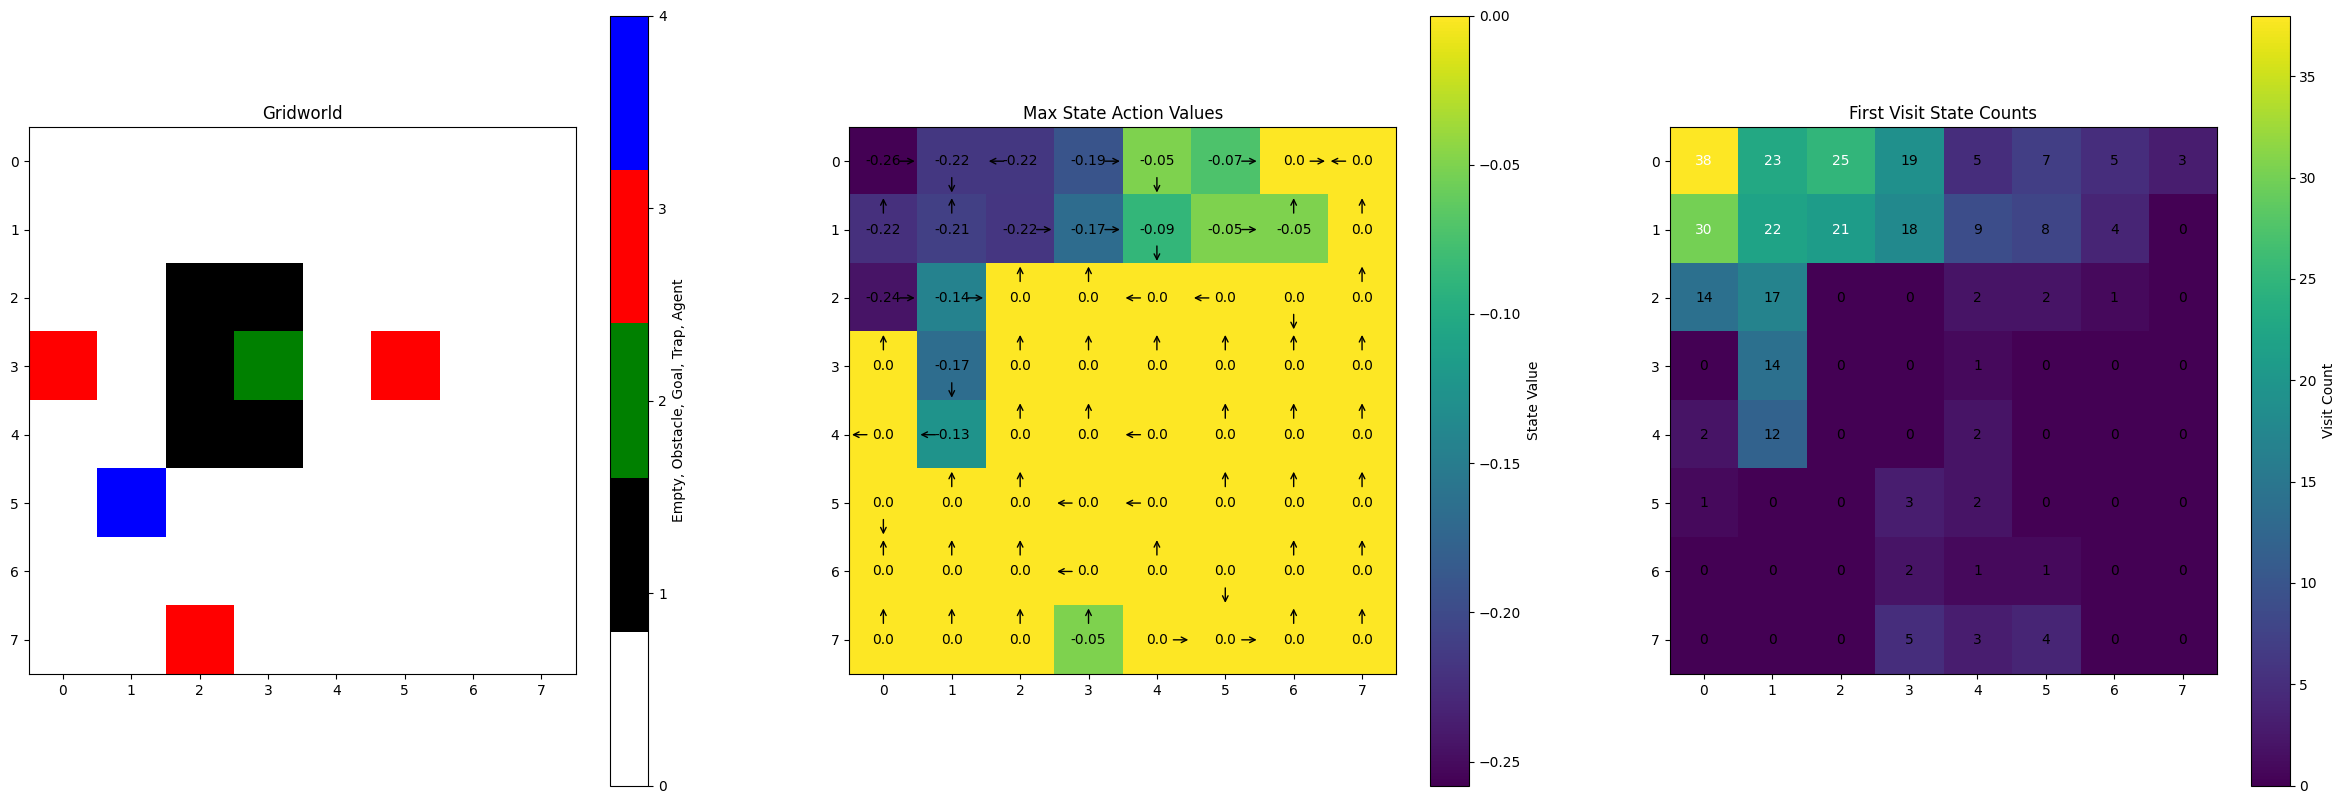

Running 100 episodes...


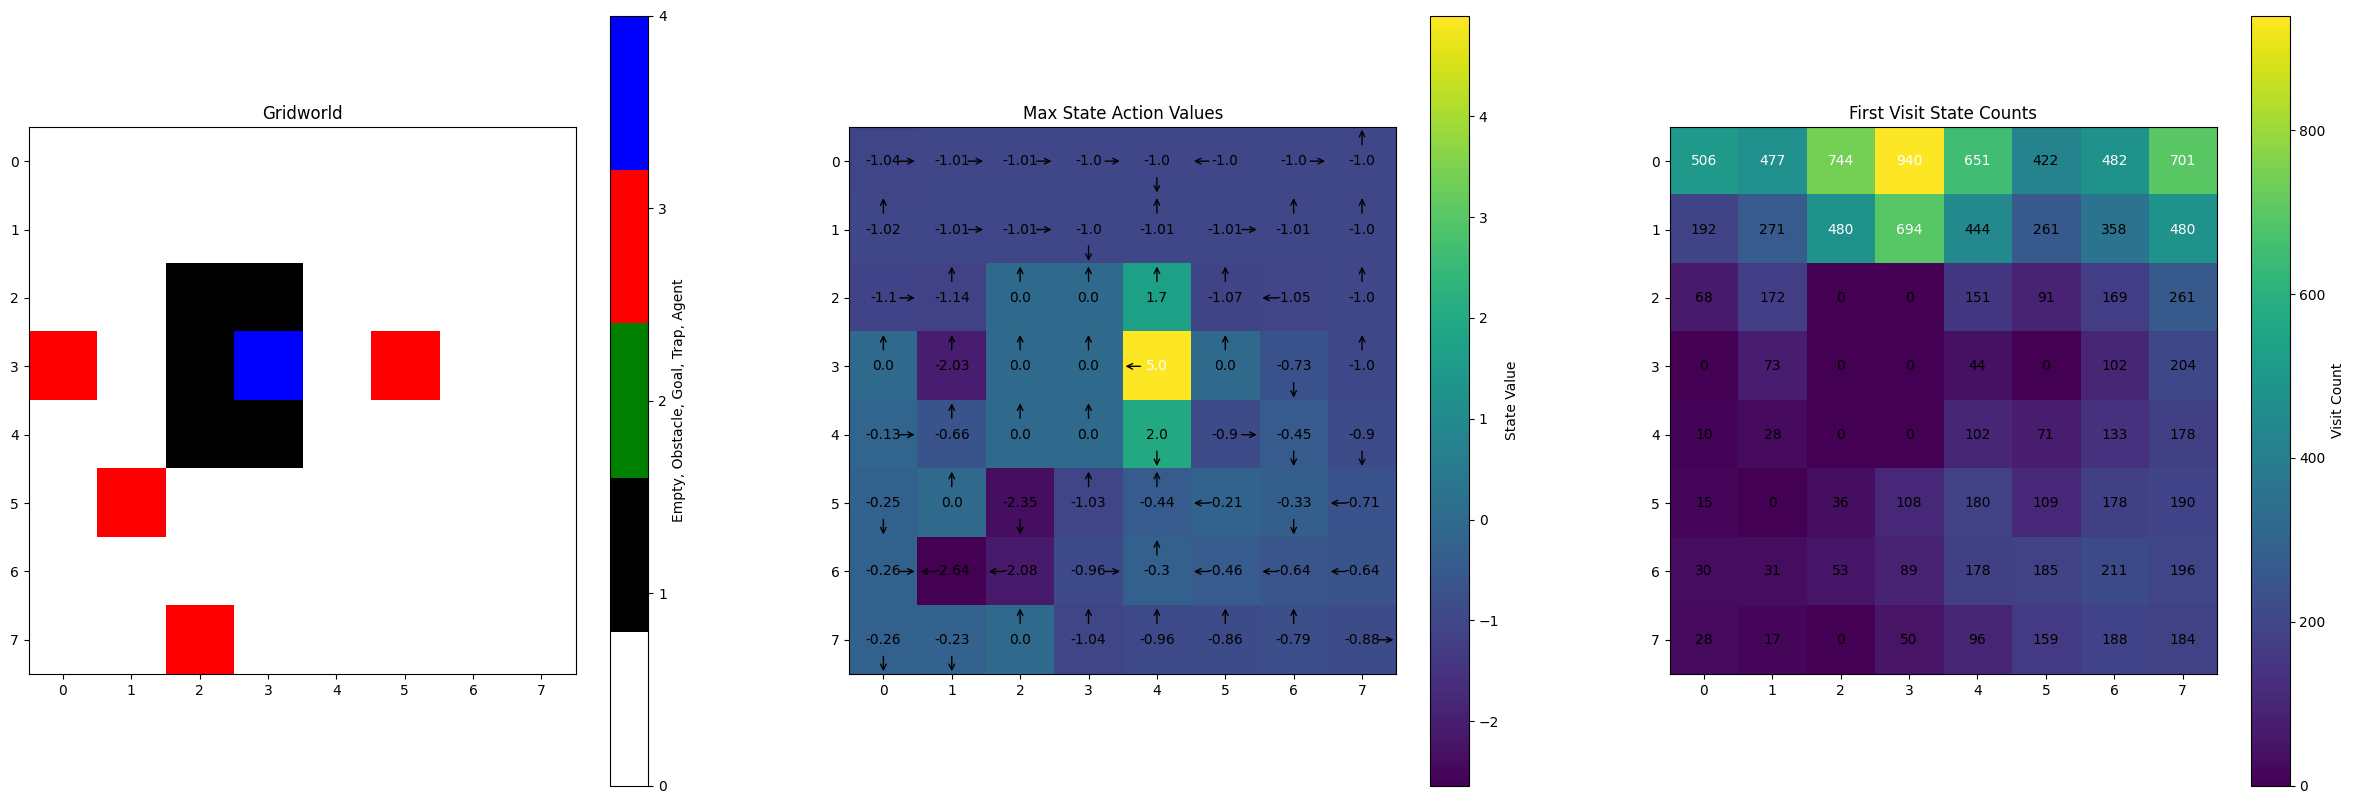

Running 1000 episodes...


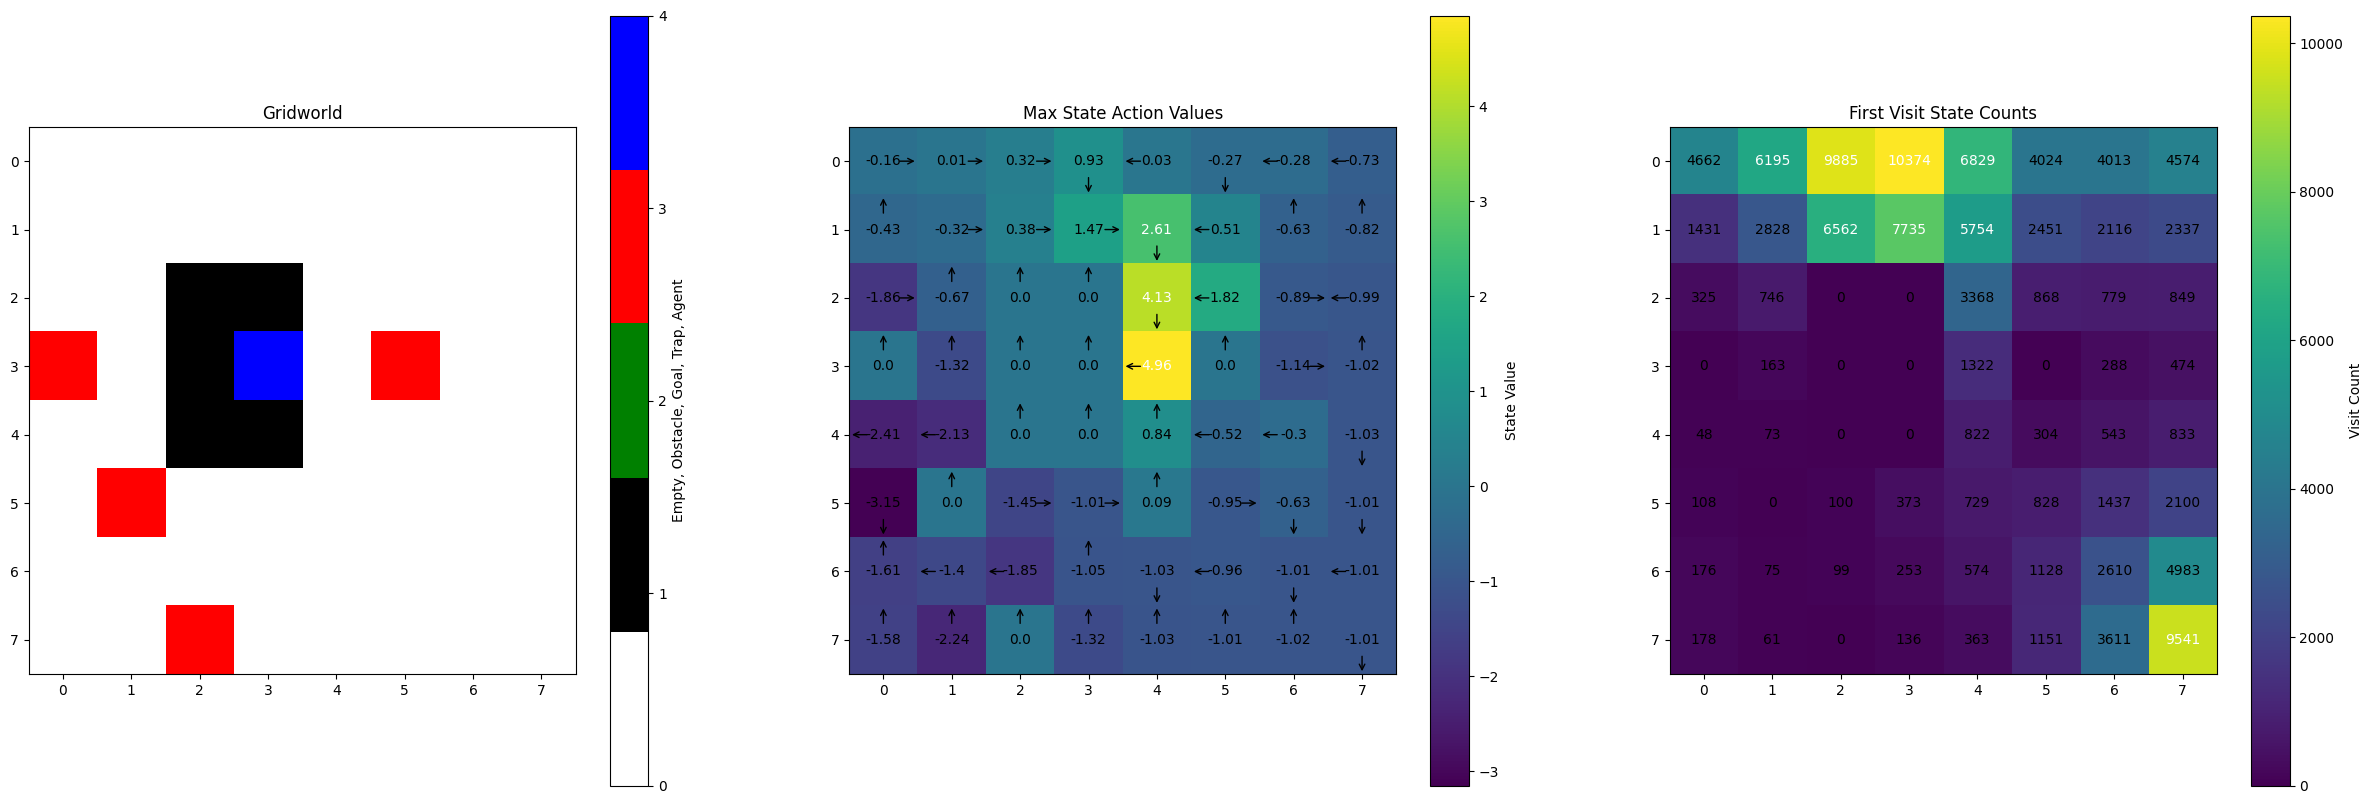

Running 10000 episodes...


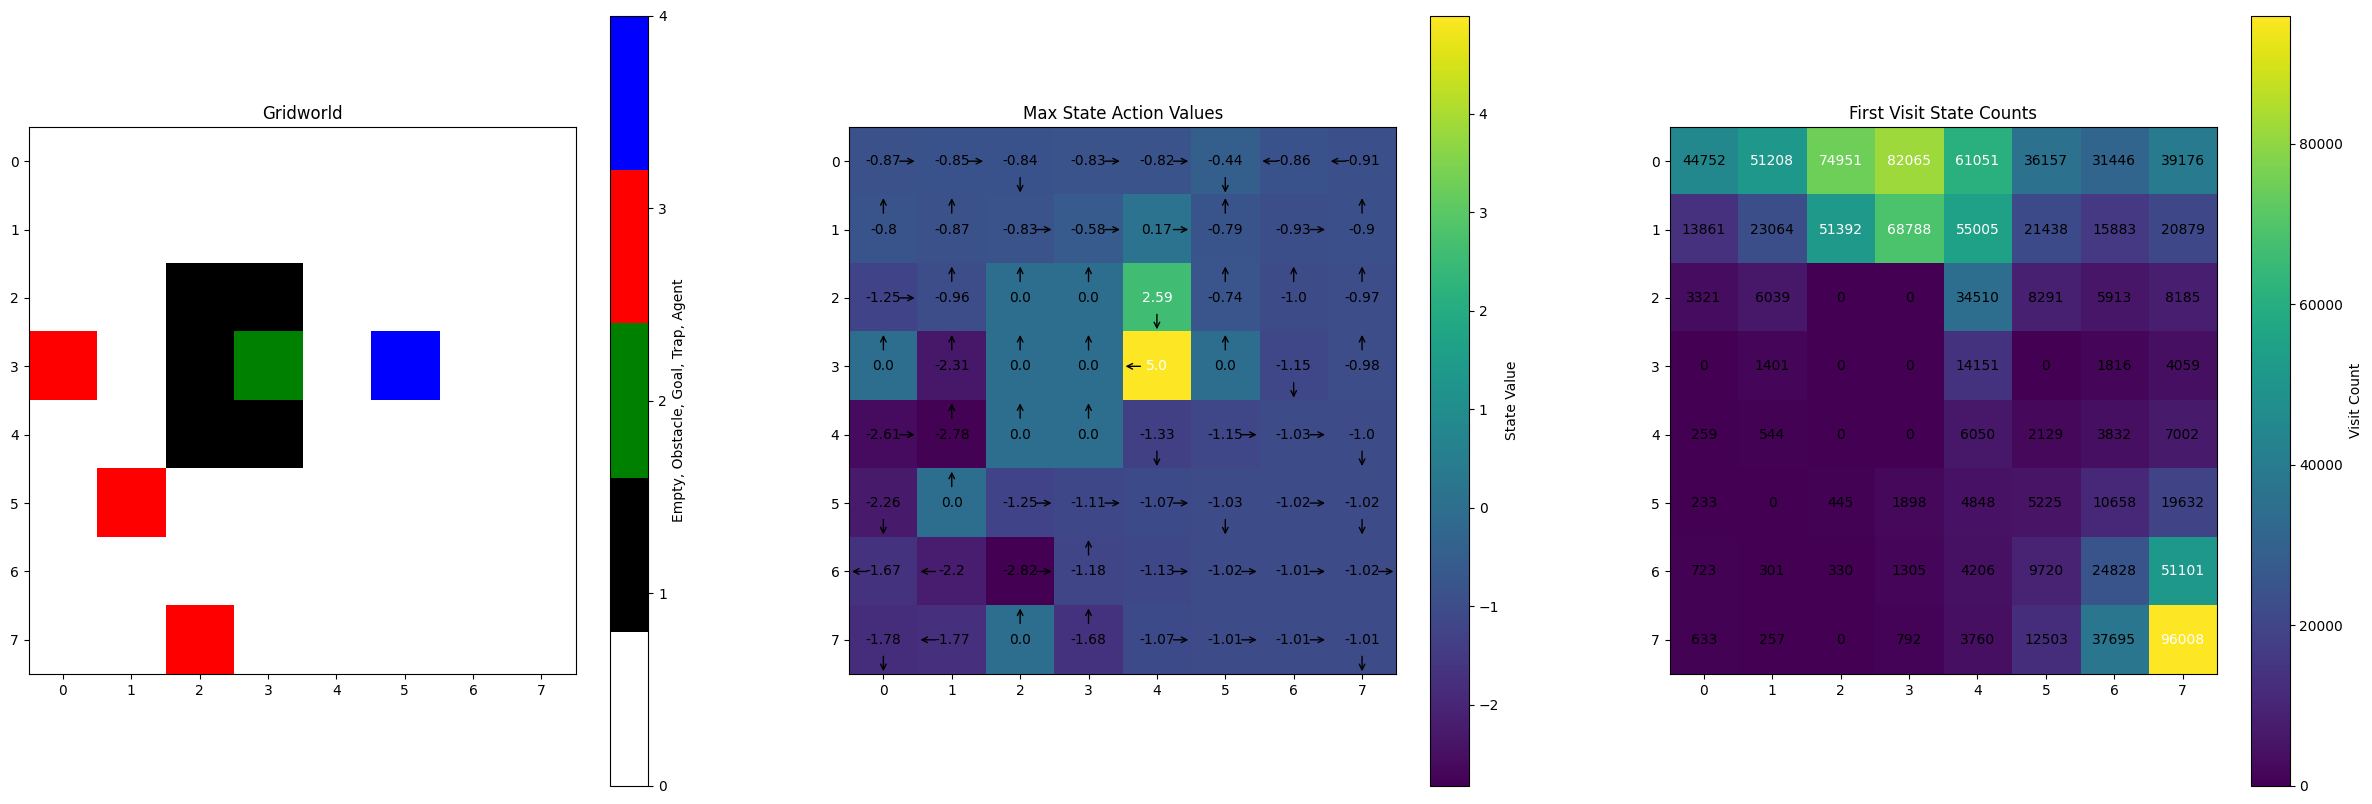

In [34]:
# Initialize gridworld and agent
env = GridWorld(grid_size=8, 
                start_state=(0,0), 
                goal_states=[(3,3)], 
                obstacles=[(2,2),(2,3),(3,2),(4,2),(4,3)], 
                traps=[(3,0),(3,5),(5,1),(7,2)])
agent = Agent(env)


for episodes in [10, 100, 1000, 10000]:
    print(f'Running {episodes} episodes...')
    values, counts = agent.sarsa_control(episodes)

In [37]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import time

class GridWorld:
    def __init__(self, grid_size, start_state, goal_states, obstacles, traps, action_penalty=-0.1):
        # state space
        self.grid_size = grid_size
        self.start_state = np.array(start_state) # give as tuple
        self.goal_states = [np.array(state) for state in goal_states] # give as list of tuples
        self.obstacles = [np.array(obstacle) for obstacle in obstacles] # give as list of tuples
        self.traps = [np.array(trap) for trap in traps] # give as list of tuples
        self.current_state = np.array(start_state) # give as tuple
        self.action_penalty = action_penalty

        # action space
        self.actions = {
            0: np.array([-1, 0]),  # up
            1: np.array([1, 0]),   # down
            2: np.array([0, -1]),  # left
            3: np.array([0, 1]),   # right
        }

        # initialize rewards
        self.rewards = np.full((self.grid_size,self.grid_size), self.action_penalty)
        for goal in self.goal_states:
            self.rewards[tuple(goal)] = 5.0
        for trap in self.traps:
            self.rewards[tuple(trap)] = -5.0
        for obstacle in self.obstacles:
            self.rewards[tuple(obstacle)] = None

    # reset method
    def reset(self):
        self.current_state = self.start_state

    # probabilistic state + deterministic reward dynamics
    def move(self, action):
        assert action in self.actions.keys(), "Invalid action!"
    
        if np.random.rand() < 0.8:  # 80% chance to move in the intended direction
            next_state = self.current_state + self.actions[action]
        else:  # 10% chance to "slip" in each orthogonal direction
            orthogonal_actions = [a for a in self.actions.keys() if a != action]
            random_action = np.random.choice(orthogonal_actions)
            next_state = self.current_state + self.actions[random_action]
    
        if self.is_valid_state(next_state):
            self.current_state = next_state
            
        reward = self.rewards[tuple(self.current_state)]

        done = False
        if self.is_terminal_state():
            done = True

        return self.current_state, reward, done

    # check whether a state is valid
    def is_valid_state(self, state):
        if any((state == obstacle).all() for obstacle in self.obstacles): # obstacle check
            return False
        if any((state < 0) | (state >= self.grid_size)): # boundary check
            return False
        return True

    # check whether a state is terminal
    def is_terminal_state(self):
        return any((self.current_state == goal).all() for goal in self.goal_states) or any((self.current_state == trap).all() for trap in self.traps)

    #################################################################################################################################################

class Agent:
    def __init__(self, gridworld, epsilon=0.2, alpha=0.5, gamma=0.9):
        self.gridworld = gridworld
        self.epsilon = epsilon
        self.alpha = alpha
        self.gamma = gamma
        self.state_action_values = np.zeros((self.gridworld.grid_size, self.gridworld.grid_size, len(self.gridworld.actions)))  
        self.state_counts = np.zeros((self.gridworld.grid_size, self.gridworld.grid_size)) 
        self.returns = []
        self.time_taken = []

    def policy(self, state):
        if np.random.rand() < self.epsilon:
            action = np.random.choice(list(self.gridworld.actions.keys()))  # select a random action
        else:
            action = np.argmax(self.state_action_values[tuple(state)])  # select the best action
        return action

    def sarsa_control(self, episodes):
        for episode in range(episodes):
            self.gridworld.reset()
            done = False
            action = self.policy(self.gridworld.current_state)  # select action according to policy
            return_value = 0
            start_time = time.time()
            while not done:
                old_state = self.gridworld.current_state.copy()  # save the current state
                new_state, reward, done = self.gridworld.move(action)  # get the new state, reward, look if we're done and move the agent according to the chosen action
                return_value += reward
                new_action = self.policy(new_state) # select action at new state according to policy               
                # update Q-value using the SARSA update rule
                old_q_value = self.state_action_values[tuple(old_state) + (action,)]
                new_q_value = self.state_action_values[tuple(new_state) + (new_action,)]
                self.state_action_values[tuple(old_state) + (action,)] = old_q_value + self.alpha * (reward + self.gamma * new_q_value - old_q_value)           
                self.state_counts[tuple(old_state)] += 1
                action = new_action
            self.returns.append(return_value)
            self.time_taken.append(time.time() - start_time)
        self.plot(np.max(self.state_action_values, axis=2), self.state_counts)
        self.plot_return_per_episode()
        self.plot_return_per_time()

        return self.state_action_values, self.state_counts, self.returns, self.time_taken

    def plot(self, values, counts):
        fig, axes = plt.subplots(1, 3, figsize=(30, 10))
    
        # Plot the gridworld
        color_map = colors.ListedColormap(['white', 'black', 'green', 'red', 'blue'])
        grid = np.zeros((self.gridworld.grid_size, self.gridworld.grid_size))
    
        for obstacle in self.gridworld.obstacles:
            grid[tuple(obstacle)] = 1
    
        for goal in self.gridworld.goal_states:
            grid[tuple(goal)] = 2
    
        for trap in self.gridworld.traps:
            grid[tuple(trap)] = 3
    
        grid[tuple(self.gridworld.current_state)] = 4
    
        im0 = axes[0].imshow(grid, cmap=color_map)
        axes[0].set_title("Gridworld")
    
        # Plot state values
        im1 = axes[1].imshow(values, cmap='viridis')
        axes[1].set_title("Max State Action Values")
        for i in range(values.shape[0]):
            for j in range(values.shape[1]):
                axes[1].text(j, i, round(values[i, j], 2), ha='center', va='center',
                             color='white' if values[i, j] > values.max() / 2 else 'black')
                
                # Adding tiny black triangles indicating the direction of the respective action
                if np.argmax(self.state_action_values, axis=2)[i,j] == 0: # up
                    axes[1].annotate("", xy=(j, i-0.5), xytext=(j, i-0.2), arrowprops=dict(arrowstyle="->", color='k'))
                elif np.argmax(self.state_action_values, axis=2)[i,j] == 1: # down
                    axes[1].annotate("", xy=(j, i+0.5), xytext=(j, i+0.2), arrowprops=dict(arrowstyle="->", color='k'))
                elif np.argmax(self.state_action_values, axis=2)[i,j] == 2: # left
                    axes[1].annotate("", xy=(j-0.5, i), xytext=(j-0.2, i), arrowprops=dict(arrowstyle="->", color='k'))
                elif np.argmax(self.state_action_values, axis=2)[i,j] == 3: # right
                    axes[1].annotate("", xy=(j+0.5, i), xytext=(j+0.2, i), arrowprops=dict(arrowstyle="->", color='k'))
    
        # Plot visit counts
        im2 = axes[2].imshow(counts, cmap='viridis')
        axes[2].set_title("First Visit State Counts")
        for i in range(counts.shape[0]):
            for j in range(counts.shape[1]):
                axes[2].text(j, i, int(counts[i, j]), ha='center', va='center',
                             color='white' if counts[i, j] > counts.max() / 2 else 'black')
    
        # Add colorbars for state values and visit counts
        fig.colorbar(im0, ax=axes[0], ticks=[0, 1, 2, 3, 4], label='Empty, Obstacle, Goal, Trap, Agent')
        fig.colorbar(im1, ax=axes[1], label='State Value')
        fig.colorbar(im2, ax=axes[2], label='Visit Count')
    
        plt.show()

    def plot_return_per_episode(self):
        plt.figure(figsize=(10, 5))
        plt.plot(np.arange(len(self.returns))+1, np.cumsum(self.returns)/np.arange(1, len(self.returns)+1))
        plt.xlabel('Episodes Sampled')
        plt.ylabel('Average Return per Episode')
        plt.title('Average Return per Episode Vs Episodes Sampled')
        plt.show()

    def plot_return_per_time(self):
        plt.figure(figsize=(10, 5))
        plt.plot(np.cumsum(self.time_taken), np.cumsum(self.returns)/np.arange(1, len(self.returns)+1))
        plt.xlabel('Wall Clock Time (seconds)')
        plt.ylabel('Average Return per Episode')
        plt.title('Average Return per Episode Vs Wall Clock Time')
        plt.show()

Running 10 episodes...


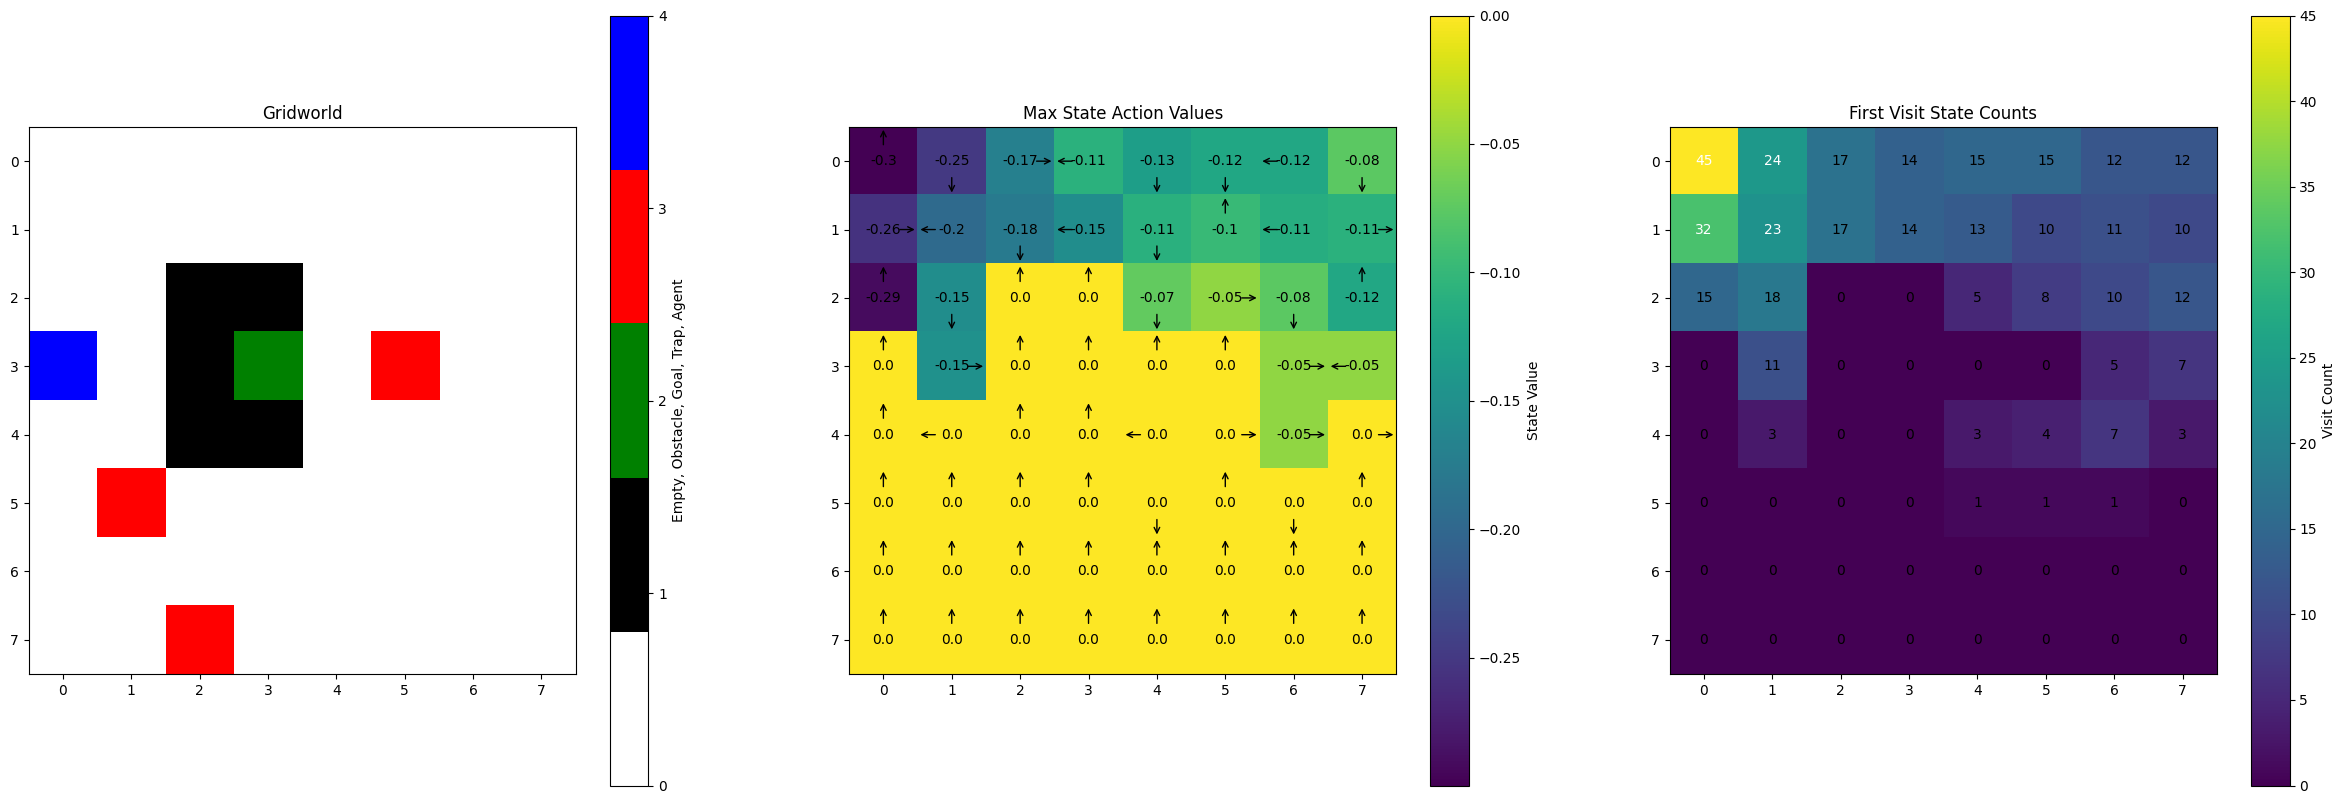

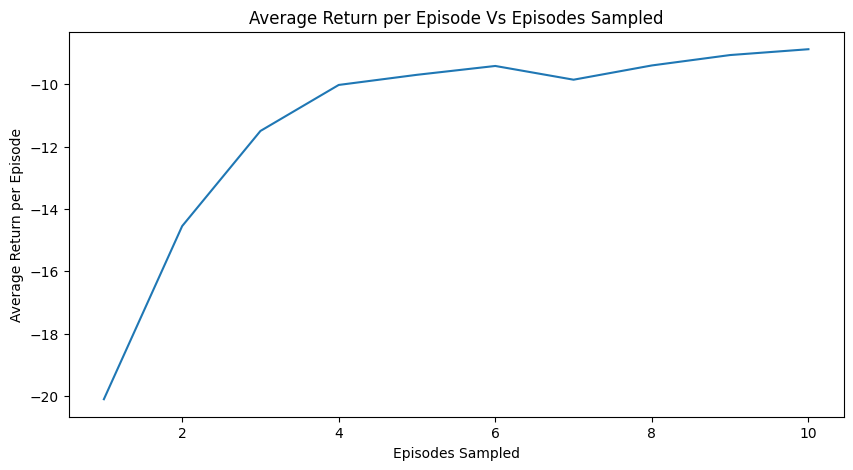

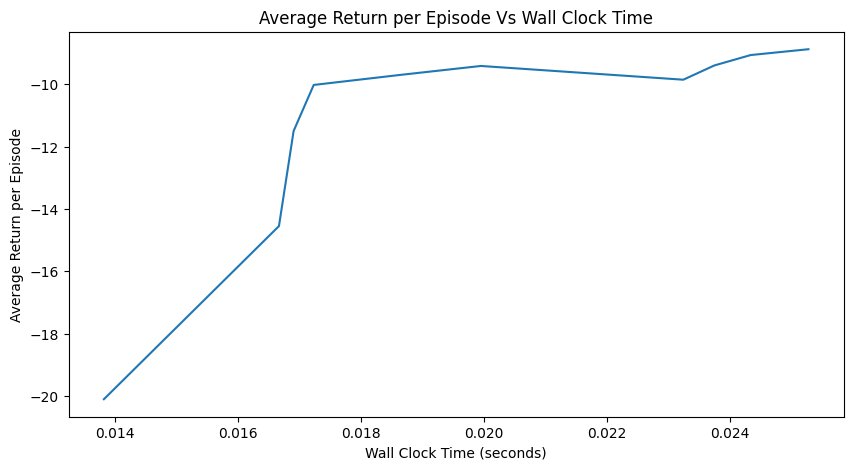

Running 100 episodes...


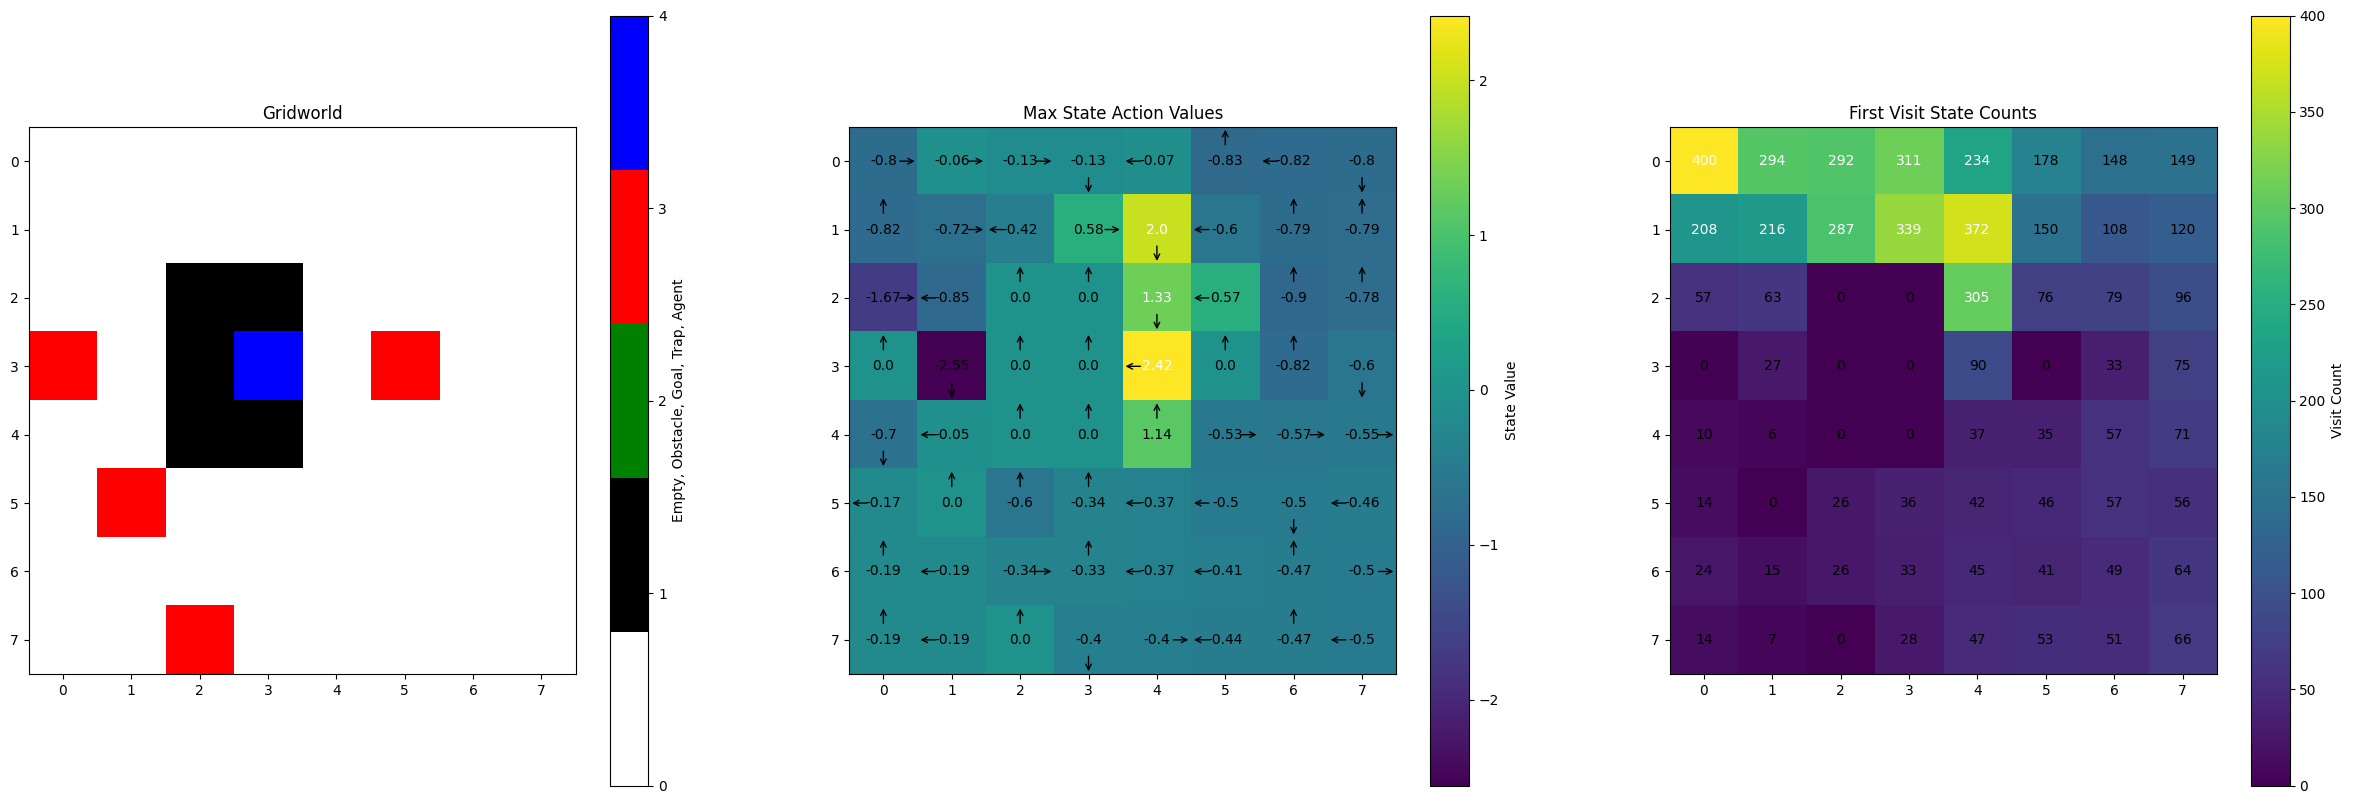

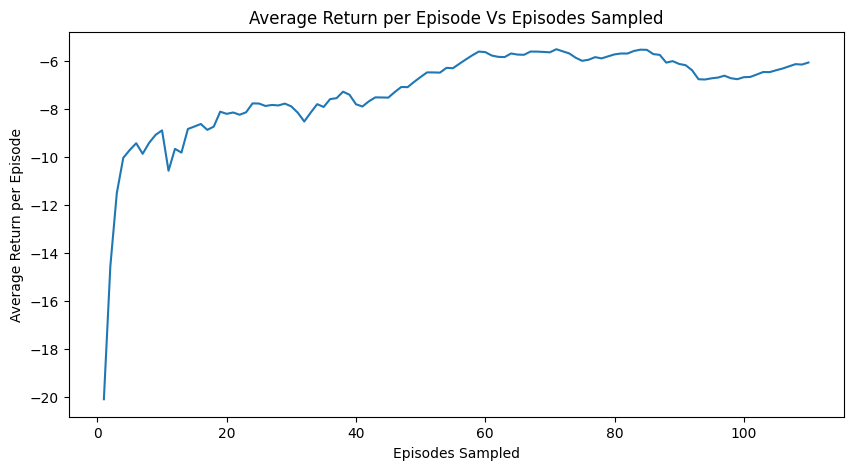

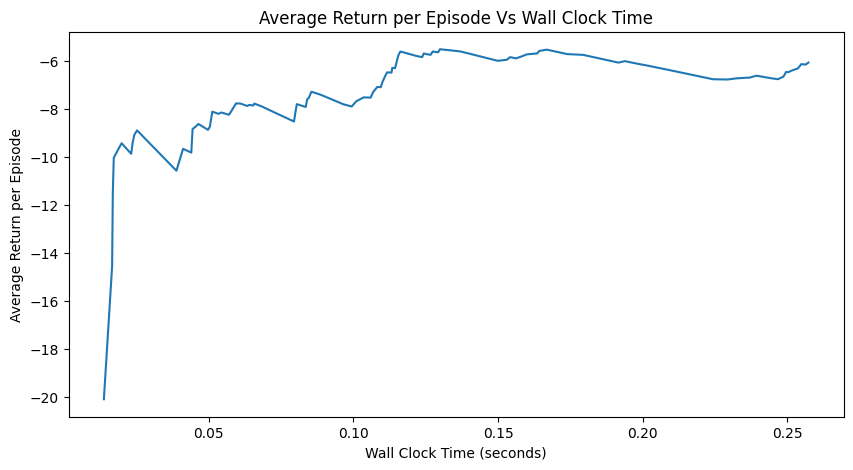

Running 1000 episodes...


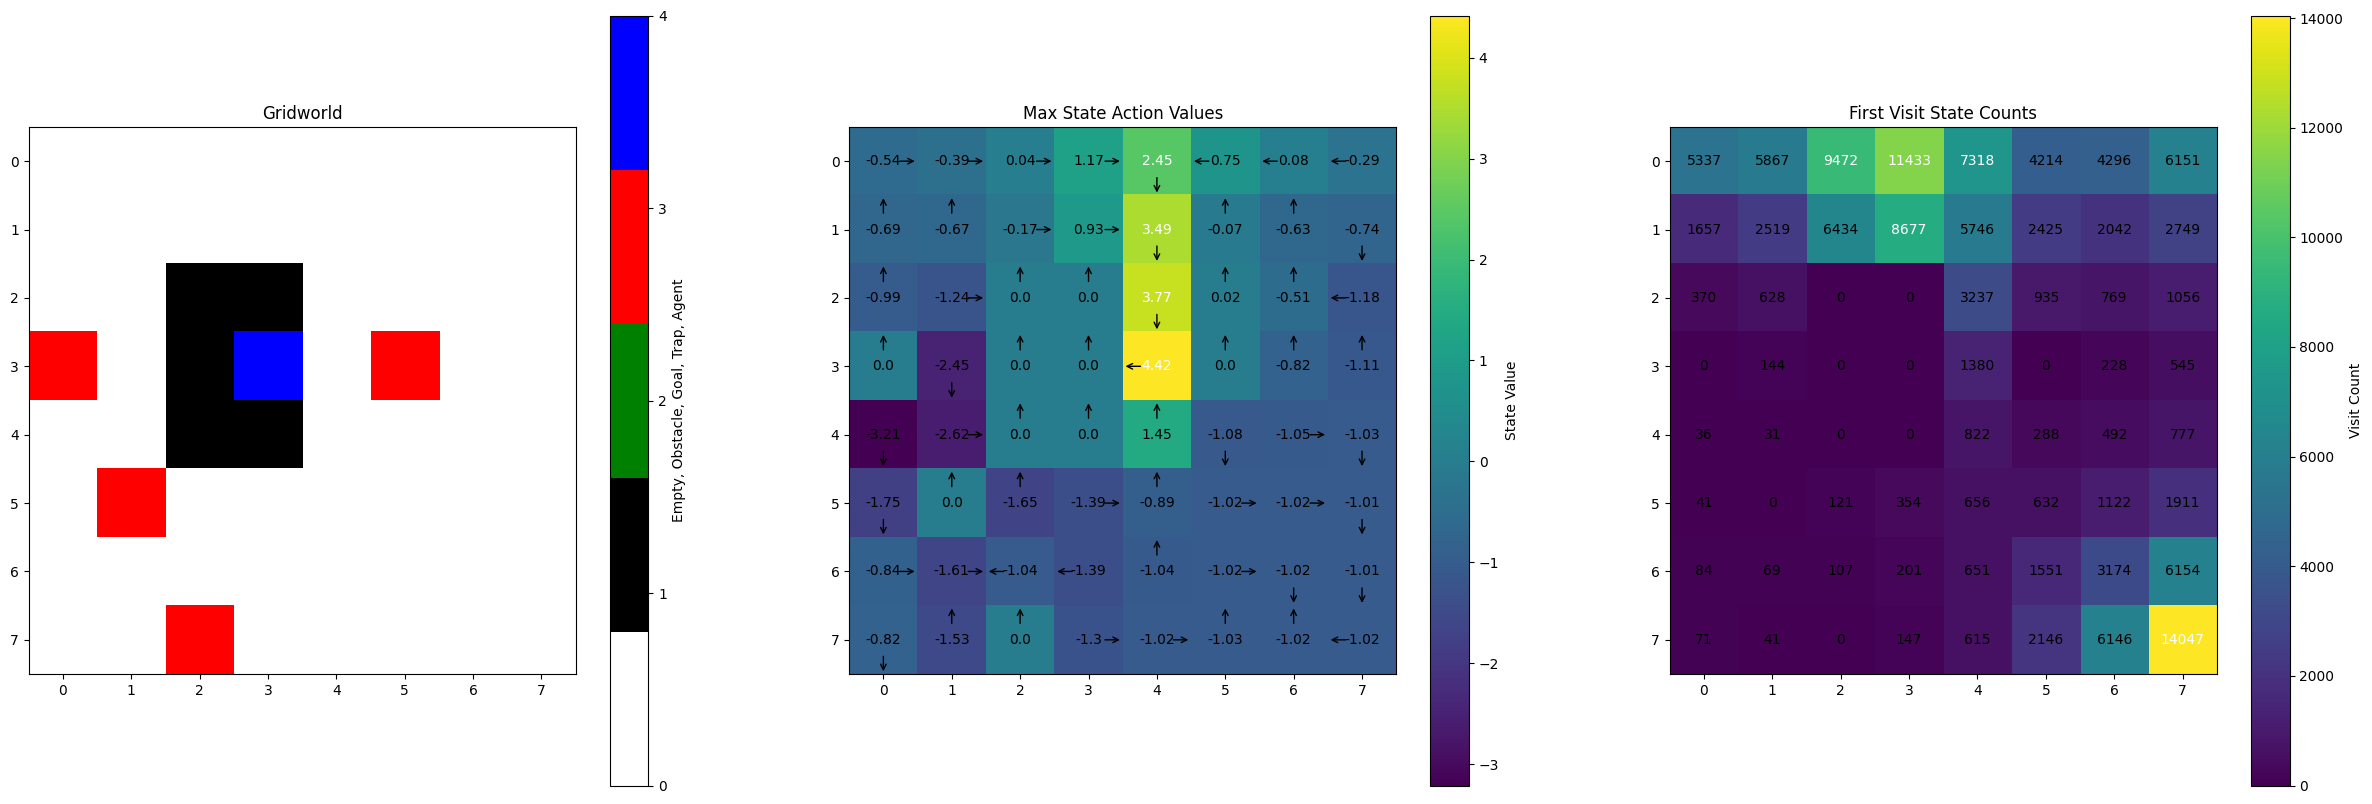

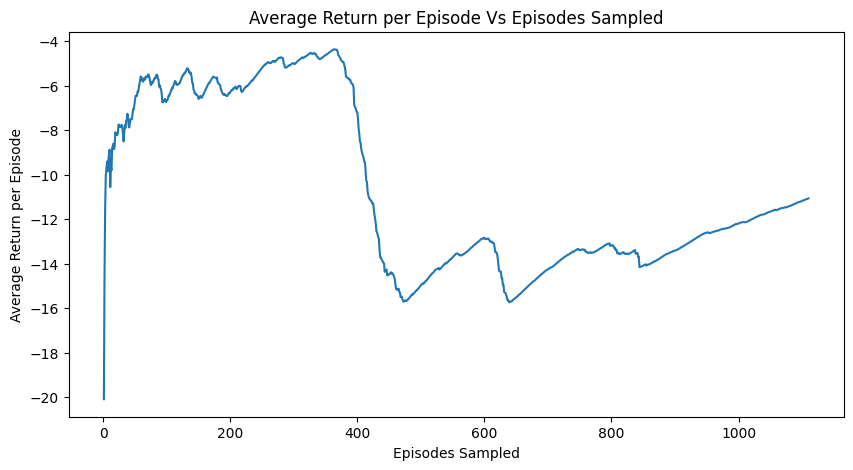

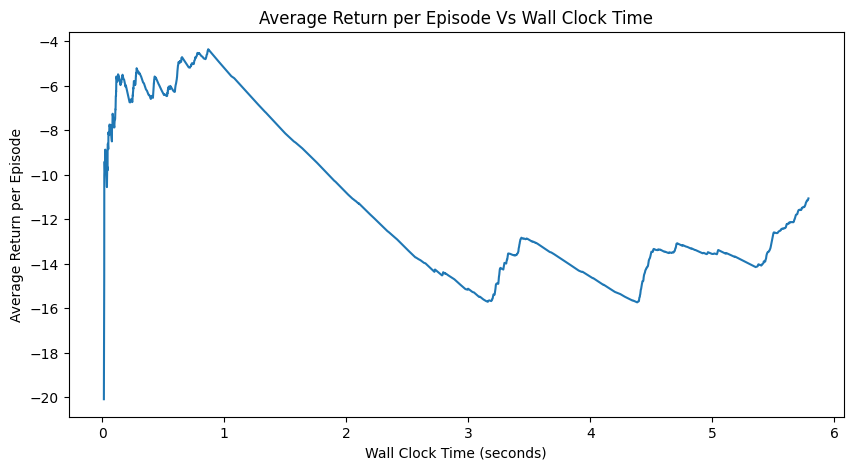

Running 10000 episodes...


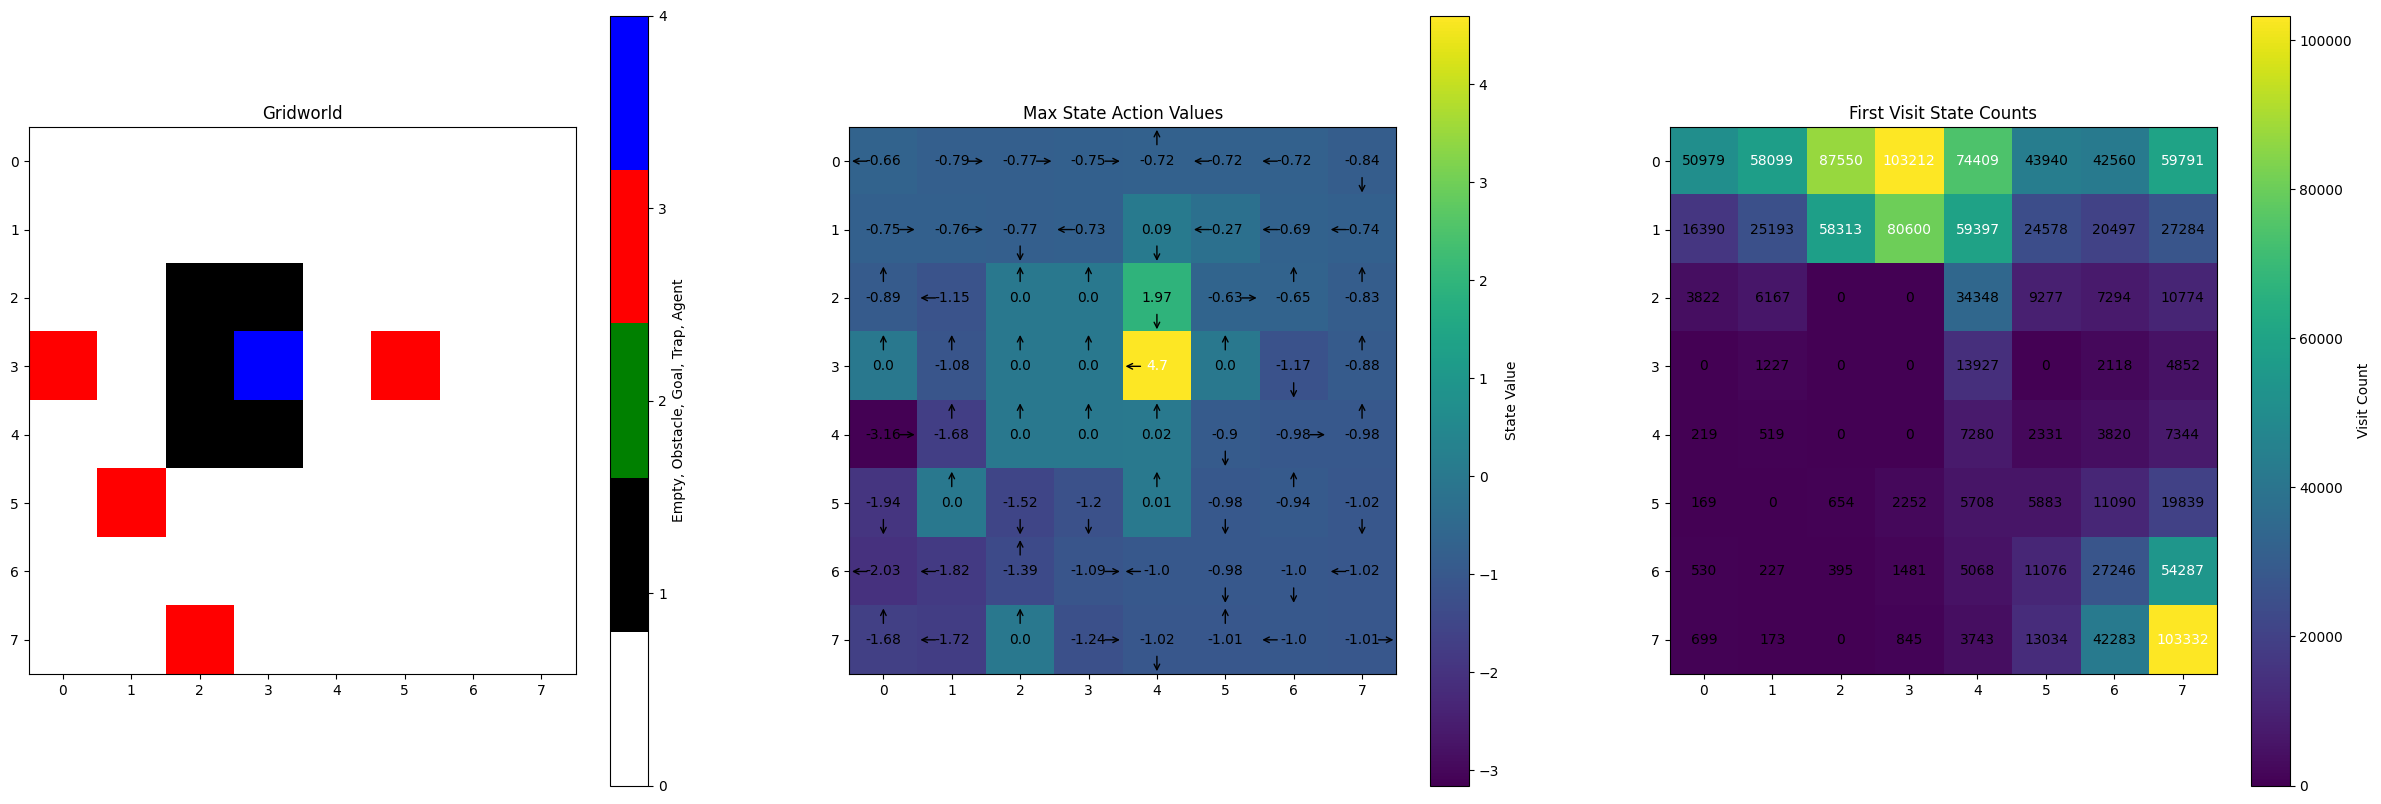

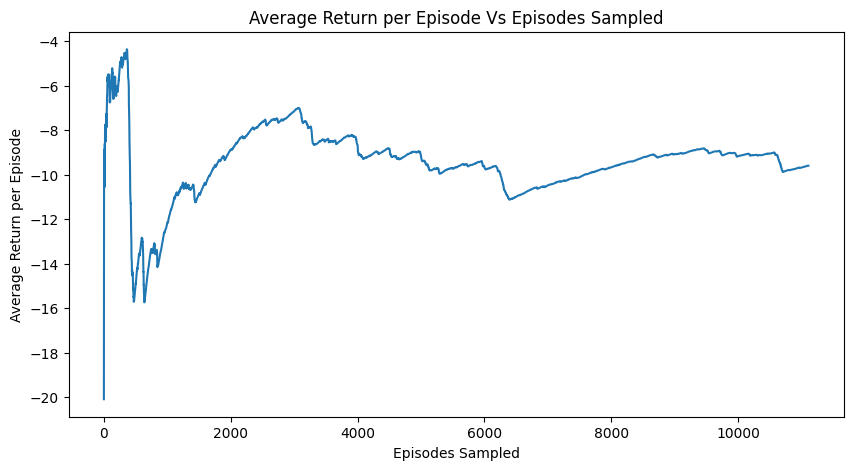

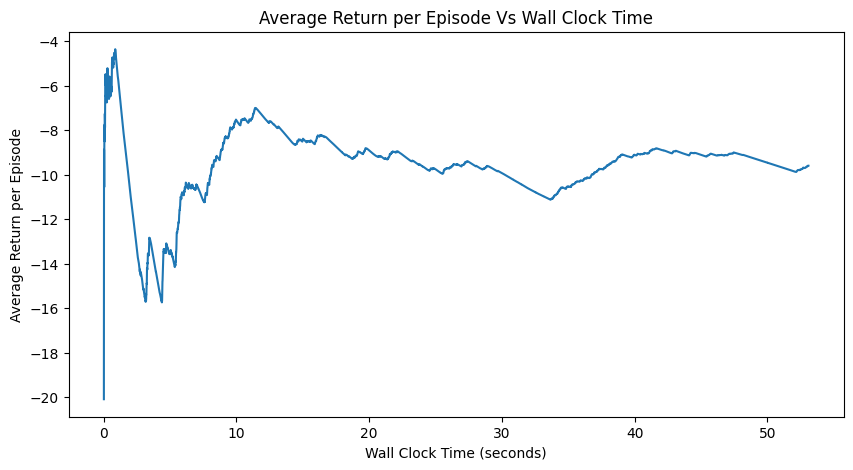

In [39]:
# Initialize gridworld and agent
env = GridWorld(grid_size=8, 
                start_state=(0,0), 
                goal_states=[(3,3)], 
                obstacles=[(2,2),(2,3),(3,2),(4,2),(4,3)], 
                traps=[(3,0),(3,5),(5,1),(7,2)])
agent = Agent(env)


for episodes in [10, 100, 1000, 10000]:
    print(f'Running {episodes} episodes...')
    agent.sarsa_control(episodes)